In [1]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import import_ipynb
import sys
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import accuracy_score


def train(Transformer, Transformer_optimizer,args,partition):
    train_loader = DataLoader(partition["train"],batch_size= args.batch_size,shuffle=False,drop_last=True)
    
    Transformer.train()
    train_loss = 0.0
    for (x,y) in train_loader:
        Transformer.zero_grad()
        Transformer_optimizer.zero_grad()

        x = x.float().to(args.device) # 64,10 40
        y = y.float().squeeze().to(args.device)

        Transf_out = Transformer(x)
        loss = args.loss_fn(Transf_out, y)

        loss.backward()

        Transformer_optimizer.step() ## parameter 갱신
        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    return Transformer, train_loss

def validation(Transformer, args, partition):
    val_loader = DataLoader(partition["val"],batch_size= args.batch_size,shuffle=False,drop_last=True)

    Transformer.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (x,y) in val_loader:

            x = x.float().to(args.device) # 64,10 40
            y = y.float().squeeze().to(args.device)

            Transf_out = Transformer(x)
                        
            loss = args.loss_fn(Transf_out, y)      
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)
    return Transformer, val_loss

def test(Transformer, args, partition):
    test_loader = DataLoader(partition["test"],batch_size= args.batch_size,shuffle=False,drop_last=True)
    
    Transformer.eval()
    ACC_metric = 0.0
    with torch.no_grad():
        for (x,y) in test_loader:

            x = x.float().to(args.device) # 64,10 40
            y = y.float().squeeze().to(args.device)

            Transf_out = Transformer(x)

            output_ = torch.where(Transf_out >= 0.5, 1.0, 0.0)

            output_.requires_grad = True

            perc_y_pred = output_.cpu().detach().numpy()     
            perc_y_true =  y.cpu().detach().numpy()
            acc = accuracy_score(perc_y_true, perc_y_pred)

            ACC_metric += acc

    ACC_metric = ACC_metric / len(test_loader)
     
    return ACC_metric


In [2]:
#====== Argument initializtion ======#
import argparse
import torch.nn as nn
parser = argparse.ArgumentParser()
args = parser.parse_args("")

#=============== Device ===============#
args.device = 'cuda' if torch.cuda.is_available() else "cpu"

#================ Path ================#

args.save_file_path = "D:\\MM_results_abla_m23"

#========= Base Hyperparameter =========#
args.batch_size = 32
args.lr = 0.00005
args.L2 = 0.00001
args.epoch = 100
args.dropout = 0.15
args.loss_fn = nn.BCELoss()

#===== Transformer Hyperparameter =====#
from Transformer_Encoder import Transformer

args.Transformer = Transformer
args.input_feature_size = 5

args.Transformer_feature_size = 64

args.nhead = 4

args.nlayer = 1
args.ts_len = 10
args.target_len = 1
# trans_feature_size / trans_nhead => int 필수


importing Jupyter notebook from Stock_Dataset.ipynb
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([3

KeyboardInterrupt: 

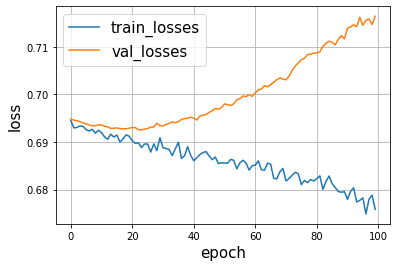

In [3]:
## 실행파일
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import time
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
from Stock_dataloader_csv_ti import stock_csv_read
from Stock_Dataset import StockDataset


args.data_list = os.listdir(r"C:\Users\lab\Desktop\MM_Transformer_early_abla_m23\data\kdd17\price_long_50")

with open(args.save_file_path + '\\' + 'Multimodal_transformer_result_t.csv', 'w', encoding='utf-8', newline='') as f:
    wr = csv.writer(f)
    wr.writerow(["model", "stock", "entire_exp_time",  "avg_test_ACC", "avg_test_ACC_std"])

    for data in args.data_list:
        est = time.time()

        stock = data.split('.')[0]

        setattr(args, 'symbol', stock)
        args.new_file_path = args.save_file_path + '\\' + "Multimodal_transformer_" + args.symbol
        os.makedirs(args.new_file_path)
        
        csv_read = stock_csv_read(data, args.ts_len,args.target_len)
        split_data_list = csv_read.cv_split()

        with open(args.new_file_path + '\\'+ str(args.symbol)+'test_acc_list' +'.csv', 'w',newline='') as alist:
            www = csv.writer(alist)
            www.writerow(["acc_list"])

            ACC_cv = []
            for i, data in enumerate(split_data_list):
                
                args.sp_ith = i

                args.split_file_path = args.new_file_path + "\\" + str(i) +"th_iter"
                os.makedirs(args.split_file_path)
                ## Model
                Transformer = args.Transformer(args.input_feature_size,
                                            args.Transformer_feature_size, args.nhead, args,
                                            args.nlayer, args.dropout, args.ts_len)
                Transformer.to(args.device)

                ##Optimizer
                Transformer_optimizer = optim.Adam(Transformer.parameters(), lr=args.lr, weight_decay=args.L2)

                ## training
                Train_losses = []
                Validation_losses = []
                for epoch in range(args.epoch):
                    ts = time.time()

                    trainset = StockDataset(data[0])
                    valset = StockDataset(data[1])
                    testset = StockDataset(data[2])


                    partition = {'train': trainset, 'val': valset, 'test': testset}     

                    Transformer, train_loss = train(Transformer,Transformer_optimizer, args, partition)
                    Transformer, validation_loss = validation(Transformer, args, partition)


                    ## .state_dict() : model의 parameter(W)만을 저장하는것임 => 다시 불러올 때 모델의 파라미터를 알고있어야함
                    if len(Validation_losses) == 0:
                        torch.save(Transformer.state_dict(), args.split_file_path + '\\' + str(epoch) +'_Transformer' +'.pt')
                    elif min(Validation_losses) > validation_loss:
                        torch.save(Transformer.state_dict(), args.split_file_path + '\\' + str(epoch) +'_Transformer' +'.pt')
                    
                    Train_losses.append(train_loss)
                    Validation_losses.append(validation_loss)
                    
                    te = time.time()

                    print('Epoch {}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'
                    .format(epoch, train_loss, validation_loss, te - ts))

                ## Test
                # state_dict로 저장했기 때문에 model의 hyperparameter를 불러와야함
                Transformer = args.Transformer(args.input_feature_size,
                                            args.Transformer_feature_size, args.nhead, args,
                                            args.nlayer, args.dropout,args.ts_len)
                Transformer.to(args.device)

                # Model_selection
                min_val_losses = Validation_losses.index(min(Validation_losses)) ## 10 epoch일 경우 0번째~9번째 까지로 나옴

                Transformer.load_state_dict(torch.load(args.split_file_path + '\\' + str(min_val_losses) +'_transformer' + '.pt'))

                ACC = test(Transformer, args, partition)
                www.writerow([ACC])
                print('ACC: {}'.format(ACC))

                with open(args.split_file_path + '\\'+ str(min_val_losses)+'Epoch_test_metric' +'.csv', 'w') as fd:
                    print('ACC: {}'.format(ACC), file=fd)

                result = {}

                result['train_losses'] = Train_losses
                result['val_losses'] = Validation_losses
                result['ACC'] = ACC

                eet = time.time()
                entire_exp_time = eet - est
                

                ## draw loss curve
                fig = plt.figure()
                plt.plot(result['train_losses'])
                plt.plot(result['val_losses'])
                plt.legend(['train_losses', 'val_losses'], fontsize=15)
                plt.xlabel('epoch', fontsize=15)
                plt.ylabel('loss', fontsize=15)
                plt.grid()
                plt.savefig(args.split_file_path + '\\' + 'fig' + '.png')
                plt.close(fig)
                ACC_cv.append(result['ACC'])

        ACC_cv_ar = np.array(ACC_cv)
        acc_avg = np.mean(ACC_cv_ar)
        acc_std = np.std(ACC_cv_ar)

        wr.writerow(["MM_Transformer", args.symbol, entire_exp_time, acc_avg, acc_std])
